In [1]:
import tensorflow as tf
import keras 
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

dataset = torchvision.datasets.MNIST(root='./data', transform=transforms.ToTensor(), train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', transform=transforms.ToTensor(), train=False, download=True)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1000, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

Using TensorFlow backend.


In [2]:
def create_robust_dataset(size_of_dataset):
    import random
    random_batch_idx = (random.randint(0, len(loader)-1))
    samples, labels = None, None 
    for idx, (samples, labels) in enumerate(loader):
        if idx == random_batch_idx:
            samples = samples.reshape(-1, 784).numpy()
            labels = labels.numpy()
            samples = samples[:size_of_dataset]
            labels = labels[:size_of_dataset]
            break
    
    return samples, labels

def create_non_robust_dataset(size_of_dataset):
    import random
    random_batch_idx = (random.randint(0, len(loader)-1))
    samples, labels = None, None 
    for idx, (samples, labels) in enumerate(loader):
        if idx == random_batch_idx:
            samples = samples.reshape(-1, 784).numpy()
            labels = labels.numpy()
            samples = samples[:size_of_dataset]
            labels = labels[:size_of_dataset]
            break
    
    return samples, labels

def create_test_dataset(size_of_dataset):
    samples, labels = None, None 
    for idx, (samples, labels) in enumerate(loader):
        if idx == 0:
            samples = samples.reshape(-1, 784).numpy()
            labels = labels.numpy()
            samples = samples[:size_of_dataset]
            labels = labels[:size_of_dataset]
            break
    
    return samples, labels

    
size_of_dataset = 600
robust_X, robust_Y = create_robust_dataset(size_of_dataset)
print(robust_X.shape, robust_Y.shape)
non_robust_X, non_robust_Y = create_non_robust_dataset(size_of_dataset)
print(non_robust_X.shape, non_robust_Y.shape)
test_X, test_Y = create_test_dataset(size_of_dataset)
print(test_X.shape, test_Y.shape)

(600, 784) (600,)
(600, 784) (600,)
(600, 784) (600,)


In [3]:
# (Both robust and non-robust) Viusalization 
'''
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(5,5))

for label_idx in range(3):
    X = [x[0] for (idx, x) in enumerate(robust_X) if robust_Y[idx] == label_idx]
    Y = [x[1] for (idx, x) in enumerate(robust_X) if robust_Y[idx] == label_idx]
    plt.scatter(X, Y)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

figure(figsize=(5,5))
for label_idx in range(3):
    X = [x[0] for (idx, x) in enumerate(non_robust_X) if non_robust_Y[idx] == label_idx]
    Y = [x[1] for (idx, x) in enumerate(non_robust_X) if non_robust_Y[idx] == label_idx]
    plt.scatter(X, Y)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()
'''
print('Visualization of dataset in high dimensional space is omitted here!')

Visualization of dataset in high dimensional space is omitted here!


In [4]:
from math import inf
from numpy.linalg import norm

num_classes = 10

def return_close_i(i, X_cluster_mean):
    min_j, min_distance = None, inf
    for j in range(len(X_cluster_mean)):
        if i != j:
            distance = norm(X_cluster_mean[j] - X_cluster_mean[i])
            if distance < min_distance:
                min_distance, min_j = distance, j
    return min_j, min_distance

def compute_robustness_indication(X, Y):
    X_cluster = []
    for class_idx in range(num_classes):
        cluster_array = [x for (idx, x) in enumerate(X) if Y[idx] == class_idx]
#         print('Length of cluster array:', len(cluster_array))
        try: 
            cluster = np.array(cluster_array)
        except: 
            print(cluster_array)
            cluster = np.array(cluster_array)
            print(cluster)
        X_cluster.append(cluster)
        
    X_cluster_mean = [np.mean(X, axis=0) for X in X_cluster]
    X_cluster_std = [np.std(X, axis=0) for X in X_cluster]

    r = 0
    for i in range(num_classes):
        close_i, close_i_distance = return_close_i(i, X_cluster_mean)
        r += close_i_distance - norm(X_cluster_std[i]) - norm(X_cluster_std[close_i])
    return r

robust_r = compute_robustness_indication(robust_X, robust_Y)
non_robust_r = compute_robustness_indication(non_robust_X, non_robust_Y)

print('Robustness indication (robust dataset):', robust_r)
print('Robustness indication (non robust dataset):', non_robust_r)

Robustness indication (robust dataset): -94.70702838897705
Robustness indication (non robust dataset): -88.27051782608032


In [5]:
# Create two models corresponding to robust and non-robust dataset 
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class NaiveC(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784, 64)
        self.layer2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.relu(self.layer1(x))
        return self.layer2(output)

def generate_NaiveC(X, Y, verbose=False):
    model = NaiveC()

    # Optimizer parameters
    loss_func = nn.CrossEntropyLoss()
    lr = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_history = []
    
    # Training
    num_of_epochs = 20
    for epoch in range(num_of_epochs):
#         print(epoch+1, '/', num_of_epochs)
        for idx, data in enumerate(X):

            data = torch.from_numpy(np.expand_dims(data, axis=0).astype(np.float32))
            label = torch.from_numpy(np.array([Y[idx]]).astype(np.int64))
    
            # Forwarding
            prediction = model.forward(data)
            loss = loss_func(prediction, label)
            if verbose:
                print('Epoch:', epoch, 'Loss:', loss)

            # Optimization (back-propogation)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())
            
    return loss_history, model
            
robust_loss_history, robust_model = generate_NaiveC(robust_X, robust_Y, verbose=True)
non_robust_loss_history, non_robust_model = generate_NaiveC(non_robust_X, non_robust_Y, verbose=True)

Epoch: 0 Loss: tensor(2.1419, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.4023, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.3881, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.2362, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.3603, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.3628, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.4783, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.8607, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.2812, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.4945, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.3425, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.1247, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.3005, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.7023, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.2972, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.1922, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.0772, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.5301, g

Epoch: 0 Loss: tensor(1.4155, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.7960, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.3898, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.7551, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.4251, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.2488, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.5467, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.3368, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.6735, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.8105, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.3739, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.8876, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.8212, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.4303, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.8757, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.2833, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.7324, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.9865, g

Epoch: 0 Loss: tensor(1.1968, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.3016, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.5753, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.1861, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.4119, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.6786, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.4335, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.9982, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.4460, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.4794, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.6061, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.6071, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.2318, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.3089, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.3777, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.2118, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.2747, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.6237, g

Epoch: 0 Loss: tensor(1.0541, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.8296, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.0225, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.5559, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.5577, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.2499, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.9118, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.0066, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.5394, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.1657, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.6439, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(3.2660, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.8357, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.4287, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.2573, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.5769, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.3431, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.6215, g

Epoch: 1 Loss: tensor(0.1205, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0808, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.5639, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0426, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.3370, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(1.1863, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(1.1670, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0323, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.2938, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0498, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.3456, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.4998, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.8724, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.4654, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(3.1569, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0865, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.9634, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0280, g

Epoch: 1 Loss: tensor(1.2653, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.2989, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1063, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0714, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0281, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1172, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0264, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0074, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0535, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0810, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(1.6604, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0406, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.6003, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.8248, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.5205, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0109, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0328, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0774, g

Epoch: 1 Loss: tensor(0.5339, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1043, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.8503, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0701, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0948, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.3762, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.5396, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0029, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.6334, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0297, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0146, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0639, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.3811, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0879, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(1.6516, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0118, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0153, g

Epoch: 1 Loss: tensor(0.1957, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1150, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.3175, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0120, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.5868, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0124, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(2.9045, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0261, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0455, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0189, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.6423, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0392, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(1.1863, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.4868, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.3165, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0103, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(1.1010, g

Epoch: 2 Loss: tensor(0.0486, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.3610, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0237, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.7624, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0364, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0037, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.3078, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0025, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0181, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.3592, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0687, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0493, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0354, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0635, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0500, g

Epoch: 2 Loss: tensor(0.0044, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0042, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1827, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.7863, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.3371, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0089, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0822, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.6583, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0431, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0092, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0970, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.3110, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.3327, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0663, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0455, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2202, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0383, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0676, g

Epoch: 2 Loss: tensor(0.2372, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(1.6739, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0508, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0993, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0605, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0781, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0060, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0901, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2875, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1481, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1034, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0342, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0040, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0039, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.5900, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0011, g

Epoch: 3 Loss: tensor(0.0720, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0135, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.3081, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0044, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0324, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.8230, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0051, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0330, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0217, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.2107, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0938, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0049, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0187, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.3333, g

Epoch: 3 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0313, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.5305, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.2911, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0850, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1638, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0081, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0432, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.3040, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0105, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0045, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0172, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0308, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0400, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0077, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0631, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.3088, g

Epoch: 3 Loss: tensor(0.5522, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.2539, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0162, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1494, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1737, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0889, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0663, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0355, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0045, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.3444, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0389, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1203, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1341, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0824, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1545, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0337, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0074, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0318, g

Epoch: 3 Loss: tensor(0.0126, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.2540, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0255, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0654, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.2224, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0718, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(1.2086, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.2306, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.2684, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1865, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0514, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.4148, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0010, g

Epoch: 4 Loss: tensor(0.1532, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0755, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0023, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.1077, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.2704, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.1035, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0117, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0600, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0021, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0065, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0486, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0214, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0217, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.3593, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0026, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.7086, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0023, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.3301, g

Epoch: 4 Loss: tensor(0.0433, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0312, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0055, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.8272, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0546, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0158, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0207, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0185, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0268, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.4667, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0121, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0272, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0070, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.5087, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0111, g

Epoch: 4 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(9.9535e-05, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0285, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0360, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.1184, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0129, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0509, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0042, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.3453, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0319, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0051, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0149, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0070, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0068, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0070, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.019

Epoch: 4 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(7.3669e-05, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.3303, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.1093, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.2350, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0789, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0192, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.2647, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0078, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.4593, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0495, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0300, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(3.9339e-06, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0391, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0

Epoch: 5 Loss: tensor(0.0123, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.1083, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.4577, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.1281, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0068, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0045, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0347, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.3391, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0036, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(1.0848e-05, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0023, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.1178, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0102, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0490, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.005

Epoch: 5 Loss: tensor(0.0408, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0339, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0034, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.1152, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(1.0967e-05, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.1627, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0100, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0769, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0043, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0248, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0728, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0068, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.1332, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0029, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.005

Epoch: 5 Loss: tensor(0.0803, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0648, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0481, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0176, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0076, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0470, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.2012, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0693, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0054, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0344, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0950, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0087, g

Epoch: 5 Loss: tensor(5.2452e-06, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0142, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0264, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0434, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0127, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0023, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0099, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0051, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0227, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0182, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0153, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(8.7496e-05, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0817, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0

Epoch: 6 Loss: tensor(0.0705, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0047, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(5.5669e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.2418, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(2.9206e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0770, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0133, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(3.4689e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(2.2650e-06, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0607, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(2.7418e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0177, grad_fn=<NllLossBackward>)
Epoch: 6 Lo

Epoch: 6 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0059, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0040, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0254, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(7.1526e-07, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0795, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0026, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0698, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(6.4373e-06, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.1125, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0082, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(2.6226e-06, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0026, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tens

Epoch: 6 Loss: tensor(4.1007e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0792, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(9.5367e-06, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0950, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0280, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0246, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0023, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0134, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0031, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0142, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0096, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0050, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0

Epoch: 6 Loss: tensor(0.0212, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0368, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0179, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0263, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0675, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(1.6928e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(2.1338e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0340, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0298, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.1788, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(5.4716e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0147, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tens

Epoch: 7 Loss: tensor(0.0042, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0031, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(5.0543e-05, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0043, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0167, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0053, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0130, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(7.4384e-05, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0719, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0232, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0097, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(2.0266e-06, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0227, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0219, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0105, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tens

Epoch: 7 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0165, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0680, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0034, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(2.8252e-05, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0106, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0135, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0139, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0285, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0085, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0074, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(3.5763e-06, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0140, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0864, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0

Epoch: 7 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0284, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0703, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0041, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(7.1526e-07, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(5.2689e-05, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0378, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0283, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0244, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0779, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(1.0729e-06, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tens

Epoch: 8 Loss: tensor(0.0038, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(9.5367e-07, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.1235, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0120, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(4.1723e-06, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(6.0556e-05, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0384, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0040, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(4.1723e-06, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0029, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0096, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(9.4175e-06, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0367, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0678, grad_fn=<NllLossBackward>)
Epoch: 8 Lo

Epoch: 8 Loss: tensor(0.0081, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0083, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(9.5959e-05, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(4.4107e-06, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0033, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0070, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0043, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0191, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0041, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0105, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0027, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(8.3446e-07, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(2.6464e-05, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: 

Epoch: 8 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0246, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0064, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0041, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0065, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0114, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0075, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(3.9219e-05, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0106, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0033, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0180, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0041, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0040, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0172, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(5.400

Epoch: 8 Loss: tensor(0.0041, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0048, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0323, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(4.7087e-05, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0073, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0059, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0028, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0102, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0038, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0580, grad_

Epoch: 9 Loss: tensor(0.0037, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0044, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0041, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0057, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0456, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0077, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0613, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(1.9193e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0., g

Epoch: 9 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0436, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0045, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(1.2636e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0084, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0212, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(1.6451e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0054, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0048, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(4.9709e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0102, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0037, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tens

Epoch: 9 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(5.7934e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(7.1526e-07, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0118, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0165, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(6.9497e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tens

Epoch: 9 Loss: tensor(2.5034e-06, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0092, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(5.3643e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0224, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(4.4107e-06, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0059, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(1.5736e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0090, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0030, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0035, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0027, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0036, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0204, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(2.8491e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Lo

Epoch: 10 Loss: tensor(9.4290e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0243, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0134, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(5.2928e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(8.3446e-07, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0091, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0119, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0063, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0035, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0028, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0283, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0060, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Ep

Epoch: 10 Loss: tensor(6.6757e-06, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0056, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0137, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(1.0610e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0041, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0032, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(2.4318e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0071, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(6.1868e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0026, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(8.1062e-06, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(7.2717e-06, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0030, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0006, grad_fn=<NllLossB

Epoch: 10 Loss: tensor(5.1260e-06, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(1.9550e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(8.1893e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(3.5285e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0083, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(7.5457e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0108, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(4.8636e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0005, grad_fn=<NllL

Epoch: 10 Loss: tensor(0.0101, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(4.4107e-06, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(4.5299e-06, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(1.1921e-06, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0058, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(3.1471e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0145, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(2.5034e-06, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0047, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(1.1682e-05, grad_fn=<NllLossBackw

Epoch: 11 Loss: tensor(9.8462e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(6.9020e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0028, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(5.5550e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0249, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0028, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0219, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(5.0068e-06, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0., grad_fn=<NllLossBackward>)
Ep

Epoch: 11 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0172, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(3.8147e-06, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0040, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0094, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(6.0797e-06, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0029, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0023, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(1.2398e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0045, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(3.3020e-05, grad_fn=<NllLossBackward>

Epoch: 11 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0058, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0055, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(3.9219e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(2.3842e-06, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(1.0371e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(5.5788e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(2.1577e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0058, grad_fn=<NllLossB

Epoch: 11 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0033, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0068, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(5.8412e-06, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0026, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0042, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0077, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(2.5034e-06, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(2.7418e-06, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(5.9605e-07, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0039, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(1.9073e-05, grad_fn=<NllLossBackward>)
Ep

Epoch: 12 Loss: tensor(2.9206e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0028, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(2.7418e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0068, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(4.1484e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0097, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(6.3656e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0076, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(1.3590e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0035, grad_fn=<NllL

Epoch: 12 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(5.2928e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(3.9339e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(9.0118e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0033, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(8.0344e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0114, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(2.1458e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0029, grad_fn=<NllLossB

Epoch: 12 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0027, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(8.2254e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0037, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0037, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(2.2053e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(1.3113e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Ep

Epoch: 12 Loss: tensor(0.0028, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0036, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0098, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(4.2915e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(6.7947e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0047, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(3.0994e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0029, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0051, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(1.4305e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(1.6689e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Ep

Epoch: 13 Loss: tensor(0.0027, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0075, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(5.9960e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(4.9113e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(2.4199e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(2.0146e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0143, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(4.7563e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0011, grad_fn=<NllLossBackw

Epoch: 13 Loss: tensor(0.0080, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(1.1921e-06, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0047, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(2.1458e-06, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(3.2186e-06, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0021, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(9.0599e-06, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(1.7881e-06, grad_fn=<NllLossBackw

Epoch: 13 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0030, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(1.5855e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0036, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(1.5378e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(5.3643e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(7.6294e-06, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(4.7684e-07, grad_fn=<NllLossBackw

Epoch: 13 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(5.9126e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(6.6757e-06, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(9.3217e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0044, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(4.1723e-06, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0011, grad_fn=<NllLossB

Epoch: 14 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.2278e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0111, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(3.2544e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(3.4212e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(7.1285e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0067, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(7.1526e-07, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(4.6967e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(4.4583e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0018, grad_fn=<NllLossB

Epoch: 14 Loss: tensor(4.7684e-06, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.1921e-06, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(9.5367e-07, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0031, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(6.1629e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0043, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(5.3285e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(5.4477e-05, grad_fn=<NllLossBackw

Epoch: 14 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.6689e-06, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(3.7908e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0027, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.6212e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(4.9351e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(7.8317e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0030, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0013, grad_fn=<NllL

Epoch: 14 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(4.7683e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(4.9351e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.7047e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0043, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(5.0782e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0037, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch:

Epoch: 15 Loss: tensor(4.3749e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(2.6583e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(6.3894e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(8.2609e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(3.9457e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(1.9431e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0057, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(6.1868e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0023, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(2.5034e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(8.9045e-05, g

Epoch: 15 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(9.2983e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(7.8317e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(2.0266e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0026, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(1.4663e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(2.8491e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(7.1526e-07, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0044, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(7.8678e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0071, grad_fn=<NllLossBackw

Epoch: 15 Loss: tensor(2.1458e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(5.7338e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(9.7751e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0028, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(3.7312e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Ep

Epoch: 15 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(9.3098e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(1.0252e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(3.3379e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0021, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0036, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(9.6559e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(7.9748e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0036, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0027, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(1.9193e-05, grad_fn=<NllLossBackward>

Epoch: 16 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(5.3644e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(4.6492e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.2636e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0021, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0031, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(2.0504e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.1921e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(4.7684e-07, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(2.1458e-06, grad_fn=<NllL

Epoch: 16 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(2.5034e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(2.2888e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(8.0701e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(7.1526e-07, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(8.7022e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.7881e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0011, grad_fn=<NllLossB

Epoch: 16 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.5497e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(2.5749e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(5.4596e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.6689e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.0729e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(3.8265e-05, grad_fn=<NllL

Epoch: 17 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.1206e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(3.4571e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(6.3537e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(3.2186e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0039, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.0490e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(7.6294e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(2.2292e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0025, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.4305e-05, grad_

Epoch: 17 Loss: tensor(1.4186e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(3.9339e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(3.7193e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(7.1526e-07, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(7.9870e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.2994e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(3.6955e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0001, grad_fn=<NllLossB

Epoch: 17 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(2.2650e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.3113e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(4.7325e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(8.3446e-07, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(7.9390e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(5.3644e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.5497e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(3.8147e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0003, grad_

Epoch: 17 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(3.9339e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(4.2676e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(7.8678e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(2.1934e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(6.1629e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(7.8437e-05, grad_fn=<NllLossBackward>)
Epoch:

Epoch: 18 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(6.6757e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.1444e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(4.7684e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(8.3446e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(5.3166e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(6.5921e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(4.4107e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0003, grad_fn=<

Epoch: 18 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(2.2411e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.7881e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.4305e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.7166e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(2.8848e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(8.3446e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(6.0795e-05, grad_

Epoch: 18 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(4.4941e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(2.1458e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(8.4638e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(4.3868e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(3.3379e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0004, grad_fn=<NllLossB

Epoch: 19 Loss: tensor(2.8610e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(1.7166e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(4.7684e-07, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(2.1100e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(4.7684e-07, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(1.0729e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(2.0266e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(3.0517e-05, grad_fn=<NllLossBackward>)
Epoch:

Epoch: 19 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(7.2717e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(1.5139e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(1.3113e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(1.0729e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(1.0967e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(9.4886e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(7.8198e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0003, g

Epoch: 19 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(8.2609e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(4.1007e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(2.9563e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(7.2717e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(3.9339e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(7.8675e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Ep

Epoch: 0 Loss: tensor(1.3597, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.4303, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.9281, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.7932, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.5009, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.5467, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.2615, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.3897, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.2139, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.2169, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.5942, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.4406, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.9165, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.2230, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.4314, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.5453, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.2279, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.4290, g

Epoch: 0 Loss: tensor(1.5077, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.0263, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.6713, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.8257, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.1400, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.6009, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.8675, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.8386, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.1111, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.7834, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.6696, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.6532, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.0708, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.0303, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.6089, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.9392, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.7431, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.6638, g

Epoch: 1 Loss: tensor(0.0131, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0911, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0434, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0464, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0284, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(2.0028, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0669, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0330, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0341, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(2.6794, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1161, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0414, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1102, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.3150, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.6705, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1248, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.4221, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(3.7149, g

Epoch: 1 Loss: tensor(0.9449, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0139, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0357, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0395, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(4.8085, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.8892, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(1.8455, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1479, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(2.2203, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.8242, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0356, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1559, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0313, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.2691, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.4825, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0853, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1915, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0445, g

Epoch: 1 Loss: tensor(0.0178, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.7125, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.2872, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0314, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0490, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1355, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0280, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.2067, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0504, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0167, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.9909, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0912, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.5945, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0317, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1002, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(1.5515, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0695, g

Epoch: 2 Loss: tensor(0.1145, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0890, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.4418, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2957, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0105, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0632, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2506, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0990, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0186, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0066, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0164, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2614, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1002, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.8754, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1823, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0419, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0348, g

Epoch: 2 Loss: tensor(0.1238, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0069, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1695, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0035, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0519, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0870, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0232, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1409, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0187, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1213, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0221, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2175, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0104, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2575, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1726, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2476, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0337, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0209, g

Epoch: 2 Loss: tensor(0.0141, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0736, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(1.0850, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0392, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.5237, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.3738, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0940, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.6890, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0688, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0127, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1065, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.5057, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.4182, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0064, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0780, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0123, g

Epoch: 3 Loss: tensor(0.3272, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0711, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0223, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0108, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0328, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0138, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1448, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0037, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0094, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0633, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0990, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0493, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(1.0611, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0084, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1347, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0156, g

Epoch: 3 Loss: tensor(0.0126, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0938, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(2.0300, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0028, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0056, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(1.4574, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0932, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1205, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0125, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0099, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0026, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0540, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.2656, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0061, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0342, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0563, g

Epoch: 4 Loss: tensor(0.0316, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0066, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0072, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.1374, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0062, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0223, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(4.5656e-05, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0053, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0071, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0177, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0091, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.2995, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0376, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0509, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.1519, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.038

Epoch: 4 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0234, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.1048, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0040, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0846, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0981, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0083, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.1845, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.5765, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0526, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0552, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0225, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0606, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0418, g

Epoch: 4 Loss: tensor(0.0389, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0127, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.2807, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0078, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.1088, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0901, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.2311, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0073, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0026, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0298, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0193, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0091, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0032, g

Epoch: 5 Loss: tensor(0.0494, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0153, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0061, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0059, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0075, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0149, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0029, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0120, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0228, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0169, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.2546, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0551, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0053, g

Epoch: 5 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0081, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0870, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0057, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0222, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0880, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0224, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0129, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(8.5469e-05, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0333, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0484, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0654, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.017

Epoch: 5 Loss: tensor(0.1590, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0031, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0583, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(3.2186e-05, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0751, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.1588, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0061, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0160, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0090, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0047, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0039, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.017

Epoch: 6 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(7.9390e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0064, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0064, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0064, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0135, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0086, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.1204, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0400, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0034, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0110, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(5.0305e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0136, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0

Epoch: 6 Loss: tensor(6.4371e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(9.8343e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0120, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0091, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0103, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0195, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0141, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0995, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0736, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0451, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.1205, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0174, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0

Epoch: 6 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0027, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0048, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0095, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.1090, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0185, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0643, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(1.3351e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0753, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0034, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0568, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0383, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0143, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.032

Epoch: 7 Loss: tensor(0.0096, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(7.5814e-05, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0098, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(7.0333e-06, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0343, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0177, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0064, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(7.0333e-06, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0301, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0124, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0244, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0063, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tens

Epoch: 7 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0068, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(2.1457e-05, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.1091, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0083, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(9.9058e-05, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0255, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.1331, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0685, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0030, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0518, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(9.3337e-05, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: 

Epoch: 7 Loss: tensor(0.1405, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0101, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0409, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0587, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0664, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0426, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0062, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.1105, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0325, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0036, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0280, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0082, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0006, g

Epoch: 8 Loss: tensor(0.0072, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0021, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(3.6955e-06, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0384, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0085, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0108, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0596, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0095, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(1.1444e-05, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(4.2795e-05, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: 

Epoch: 8 Loss: tensor(0.0931, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0371, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0021, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0380, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(4.1603e-05, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0608, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0090, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(3.8623e-05, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0029, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(7.3549e-05, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0076, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tens

Epoch: 8 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0028, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(9.4171e-05, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0410, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0075, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(9.7151e-05, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0090, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(2.3842e-06, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0284, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0263, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0102, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tens

Epoch: 9 Loss: tensor(0.0105, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(1.5497e-06, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0021, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0023, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0043, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0085, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0121, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(6.6757e-06, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.000

Epoch: 9 Loss: tensor(0.0268, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0369, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0045, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0052, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0108, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0218, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0117, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(2.3603e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0200, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0111, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.002

Epoch: 9 Loss: tensor(0.0239, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(1.1444e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(2.1577e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0023, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(5.8292e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0061, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0161, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(1.0133e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(3.2305e-05, grad_fn=<NllLossBackward>)
Epoc

Epoch: 10 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(2.1457e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0065, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(2.9683e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(7.1526e-07, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(7.2717e-06, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0153, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(8.4516e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(4.7684e-07, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(6.7709e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0265, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0072, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(8.7496e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0103, grad_fn=<

Epoch: 10 Loss: tensor(0.0146, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0400, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(7.5102e-06, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(3.2067e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(1.5497e-06, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(4.6610e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0241, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(1.4186e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0096, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0451, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0153, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0013, grad_fn=<NllLossBackw

Epoch: 10 Loss: tensor(0.0094, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0062, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(2.1458e-06, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0114, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(9.8224e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0147, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0041, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(9.4175e-06, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(7.1165e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(3.8861e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0028, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(8.4638e-06, grad_fn=<NllL

Epoch: 11 Loss: tensor(0.0078, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0119, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0255, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(8.5830e-06, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0087, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(5.1260e-06, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0091, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(6.6517e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0043, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0033, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch:

Epoch: 11 Loss: tensor(1.3828e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0137, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0021, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0080, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0036, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0119, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0094, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0083, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(8.5469e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(1.7762e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(3.5763e-06, grad_fn=<NllLossBackward>

Epoch: 11 Loss: tensor(4.8517e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0079, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0091, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(4.8994e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0084, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0251, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0045, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0049, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(9.8700e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(9.9654e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0056, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0014, grad_fn=<NllLossBackward>

Epoch: 12 Loss: tensor(0.0063, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0079, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(2.0385e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(1.6570e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0034, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(9.4886e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0084, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(4.0888e-05, grad_fn=<NllLossB

Epoch: 12 Loss: tensor(3.4570e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0053, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0023, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(1.0014e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0078, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(1.4305e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0094, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(1.4305e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(5.9605e-07, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0011, grad_fn=<NllLossBackw

Epoch: 12 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0069, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0051, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0021, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(5.3644e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0027, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0045, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(4.6492e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(2.3126e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(8.7019e-05, grad_fn=<NllLossB

Epoch: 13 Loss: tensor(2.3842e-06, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(4.7684e-06, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0066, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0027, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0025, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(1.7762e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(1.5497e-06, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0026, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(1.0014e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(7.4503e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(8.2489e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(1.6689e-06, grad_fn=<

Epoch: 13 Loss: tensor(0.0039, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(2.0266e-06, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(2.2411e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0045, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0104, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0069, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(5.9605e-07, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(1.3113e-06, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(1.9908e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0038, grad_fn=<NllLossBackward>

Epoch: 13 Loss: tensor(3.9457e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0025, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0048, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(3.0875e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0056, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0033, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0021, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(8.4638e-06, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0030, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(3.7312e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0011, grad_fn=<NllLossB

Epoch: 14 Loss: tensor(3.7908e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(4.3272e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.1921e-06, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0032, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(2.2292e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(6.7949e-06, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0058, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.0371e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.4067e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0106, grad_fn=<NllLossBackw

Epoch: 14 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0030, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(9.0237e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(7.2715e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0041, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.4305e-06, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0033, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(6.4373e-06, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(3.4332e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(6.8901e-05, grad_fn=<NllLossB

Epoch: 14 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0042, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(9.6912e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(9.2983e-06, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.5497e-06, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0035, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(3.2186e-06, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0033, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.3113e-06, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(9.5367e-07, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0004, grad_fn=<NllLossBackw

Epoch: 15 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(2.7418e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(4.6729e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(1.4305e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(2.8610e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(8.7138e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0023, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(1.0729e-05, grad_fn=<

Epoch: 15 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(1.2755e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0056, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(2.2888e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(1.8954e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0050, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0021, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(2.0266e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(1.0610e-05, grad_fn=<NllLossBackw

Epoch: 16 Loss: tensor(4.5299e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(3.2186e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.3590e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.6451e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(4.7684e-07, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.1682e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(2.2650e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0031, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(3.6955e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0003, grad_fn=<NllL

Epoch: 16 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(4.8876e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.7881e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.2875e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(7.2715e-05, grad_fn=<NllLossB

Epoch: 17 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(9.0476e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0031, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.1563e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(7.7125e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.9312e-05, grad_fn=<NllLossBackward>)
Ep

Epoch: 17 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.3947e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0032, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(5.2808e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(8.3446e-07, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.0729e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(2.0266e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(9.8462e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0008, grad_fn=<NllL

Epoch: 17 Loss: tensor(8.9641e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(2.2650e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(2.1100e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(4.3034e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(2.6226e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.6689e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(4.8875e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.4305e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0006, grad_fn=<NllL

Epoch: 18 Loss: tensor(3.4332e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.4901e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(4.7087e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(6.1987e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(3.7789e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.2755e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(4.5299e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.6808e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(5.4239e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(3.0994e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tens

Epoch: 18 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(8.1062e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(3.6955e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(8.3446e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(3.5881e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.0014e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.4305e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(6.9020e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0007, grad_fn=<NllLossB

Epoch: 18 Loss: tensor(6.0797e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(2.0504e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(4.7683e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.6570e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.7881e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(8.0344e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(5.7457e-05, grad_fn=<

Epoch: 19 Loss: tensor(5.0543e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(9.5367e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(5.9605e-07, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(1.6332e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(1.5497e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(1.5497e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(8.5830e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossB

Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(1.3113e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(7.2717e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(7.7125e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(5.4835e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(8.3446e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(1.1206e-05, grad_fn=<NllLossBackw

Epoch: 19 Loss: tensor(2.2530e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(1.1921e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(5.9605e-07, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(2.4318e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(5.9605e-07, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(1.6689e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(2.3842e-07, grad_fn=<NllLossB

In [6]:
def eval_model(X, Y, model):
    datas = torch.from_numpy(X.astype(np.float32))
    labels = torch.from_numpy(Y.astype(np.int64))

    # Forwarding
    outputs = model.forward(datas).detach().numpy()
    predictions = np.argmax(outputs, axis=1)

    total = labels.shape[0]
    correct = (predictions == labels.numpy()).sum().item()
    acc = correct/total
    
    return acc

robust_acc = eval_model(robust_X, robust_Y, robust_model)
print('Robust model accurancy:', robust_acc)

non_robust_acc = eval_model(non_robust_X, non_robust_Y, non_robust_model)
print('Non robust model accurancy:', non_robust_acc)

Robust model accurancy: 1.0
Non robust model accurancy: 1.0


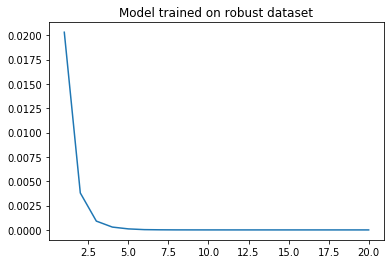

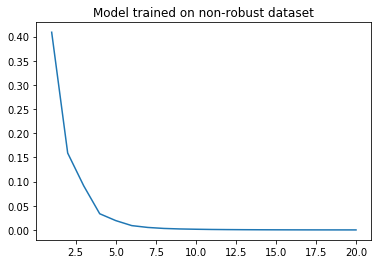

In [7]:
# Visualize the training process 
%matplotlib inline 
import matplotlib.pyplot as plt

y = [robust_loss_history[i] for i in np.arange(len(robust_loss_history)) if (i+1)%size_of_dataset==0]
x = [i+1 for i in np.arange(len(y))]
x = np.array(x)
plt.plot(x, y)
plt.title('Model trained on robust dataset')
plt.show()

y = [non_robust_loss_history[i] for i in np.arange(len(non_robust_loss_history)) if (i+1)%size_of_dataset==0]
x = [i+1 for i in np.arange(len(y))]
x = np.array(x)
plt.plot(x, y)
plt.title('Model trained on non-robust dataset')
plt.show()

In [8]:
# Measure attack success rate 
# 1. Design (apply) adversarial attacks 
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + (epsilon * sign_data_grad)
    # Return the perturbed image
    return perturbed_image

def test(model, epsilon, X, Y, verbose=False):

    # Accuracy counter
    correct = 0
    success_count = 0
    adv_examples = []

    # Loop over all examples in test set
    for idx, data in enumerate(X):
        data = torch.from_numpy(np.expand_dims(data, axis=0).astype(np.float32))
        target = np.array([Y[idx]]).astype(np.int64)
        target = torch.from_numpy(target)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model.forward(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model.forward(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
        else:
            success_count += 1

    # Calculate final accuracy for this epsilon
    final_sucess_rate = success_count/float(Y.shape[0])
    if verbose:
        print("Epsilon: {}\tSuccess Rate = {} / {} = {}".format(epsilon, success_count, Y.shape[0], final_sucess_rate))
    
    return final_sucess_rate

epsilons = [0, .01, .02, .03, .05, .1, .15, .2]
robust_pretrained_model = robust_model.eval()
non_robust_pretrained_model = non_robust_model.eval()
use_cuda=False

robust_attack_success_rate, non_robust_attack_success_rate = [], []
# Run test for each epsilon (robust)
for eps in epsilons:
    robust_attack_success_rate.append(test(robust_model, eps, test_X, test_Y, verbose=True))
    
print()
# Run test for each epsilon (non robust)
for eps in epsilons:
    non_robust_attack_success_rate.append(test(non_robust_model, eps, test_X, test_Y, verbose=True))

Epsilon: 0	Success Rate = 0 / 600 = 0.0
Epsilon: 0.01	Success Rate = 34 / 600 = 0.056666666666666664
Epsilon: 0.02	Success Rate = 77 / 600 = 0.12833333333333333
Epsilon: 0.03	Success Rate = 117 / 600 = 0.195
Epsilon: 0.05	Success Rate = 242 / 600 = 0.4033333333333333
Epsilon: 0.1	Success Rate = 487 / 600 = 0.8116666666666666
Epsilon: 0.15	Success Rate = 517 / 600 = 0.8616666666666667
Epsilon: 0.2	Success Rate = 522 / 600 = 0.87

Epsilon: 0	Success Rate = 0 / 600 = 0.0
Epsilon: 0.01	Success Rate = 31 / 600 = 0.051666666666666666
Epsilon: 0.02	Success Rate = 72 / 600 = 0.12
Epsilon: 0.03	Success Rate = 117 / 600 = 0.195
Epsilon: 0.05	Success Rate = 221 / 600 = 0.36833333333333335
Epsilon: 0.1	Success Rate = 469 / 600 = 0.7816666666666666
Epsilon: 0.15	Success Rate = 507 / 600 = 0.845
Epsilon: 0.2	Success Rate = 511 / 600 = 0.8516666666666667


In [9]:
print('Robustness indication (robust dataset):', robust_r)
print('Robustness indication (non robust dataset):', non_robust_r)

great_indication_count = 0
num_of_comparision = len(robust_attack_success_rate)
if robust_r < non_robust_r:
    for i in range(num_of_comparision):
        if robust_attack_success_rate[i] >= non_robust_attack_success_rate[i]:
            great_indication_count += 1
elif robust_r > non_robust_r:
    for i in range(num_of_comparision):
        if robust_attack_success_rate[i] <= non_robust_attack_success_rate[i]:
            great_indication_count += 1
else:
    print('Weird, it merely impossible for two robustness indication to the same!')

print(great_indication_count, num_of_comparision, great_indication_count/num_of_comparision)

Robustness indication (robust dataset): -94.70702838897705
Robustness indication (non robust dataset): -88.27051782608032
8 8 1.0


In [10]:
num_of_trails = 30
cum_related_rate = 0

for trail_idx in range(num_of_trails):
    print('Trail:', trail_idx+1)

    size_of_dataset = 500
    robust_X, robust_Y = create_robust_dataset(size_of_dataset)
    non_robust_X, non_robust_Y = create_non_robust_dataset(size_of_dataset)

    robust_r = compute_robustness_indication(robust_X, robust_Y)
    non_robust_r = compute_robustness_indication(non_robust_X, non_robust_Y)

    robust_loss_history, robust_model = generate_NaiveC(robust_X, robust_Y)
    non_robust_loss_history, non_robust_model = generate_NaiveC(non_robust_X, non_robust_Y)

    
#     epsilons = [.02, .03, 0.5, 0.8, .1]
    epsilons = [.1]
    
    
    robust_pretrained_model = robust_model.eval()
    non_robust_pretrained_model = non_robust_model.eval()
    use_cuda=False

    robust_attack_success_rate, non_robust_attack_success_rate = [], []
    # Run test for each epsilon (robust)
    for eps in epsilons:
        robust_attack_success_rate.append(test(robust_model, eps, test_X, test_Y))

    # Run test for each epsilon (non robust)
    for eps in epsilons:
        non_robust_attack_success_rate.append(test(non_robust_model, eps, test_X, test_Y))

    great_indication_count = 0
    num_of_comparision = len(robust_attack_success_rate)
    if robust_r < non_robust_r:
        for i in range(num_of_comparision):
            if robust_attack_success_rate[i] >= non_robust_attack_success_rate[i]:
                great_indication_count += 1
    elif robust_r > non_robust_r:
        for i in range(num_of_comparision):
            if robust_attack_success_rate[i] <= non_robust_attack_success_rate[i]:
                great_indication_count += 1
    else:
        print('Weird, it merely impossible for two robustness indication to the same!')

    print(great_indication_count, num_of_comparision, great_indication_count/num_of_comparision)
    cum_related_rate += great_indication_count/num_of_comparision
    
print(cum_related_rate/num_of_trails)

Trail: 1
0 1 0.0
Trail: 2
1 1 1.0
Trail: 3
1 1 1.0
Trail: 4
0 1 0.0
Trail: 5
1 1 1.0
Trail: 6
0 1 0.0
Trail: 7
1 1 1.0
Trail: 8
1 1 1.0
Trail: 9
1 1 1.0
Trail: 10
1 1 1.0
Trail: 11
1 1 1.0
Trail: 12
1 1 1.0
Trail: 13
1 1 1.0
Trail: 14
1 1 1.0
Trail: 15
0 1 0.0
Trail: 16
Weird, it merely impossible for two robustness indication to the same!
0 1 0.0
Trail: 17
1 1 1.0
Trail: 18
1 1 1.0
Trail: 19
1 1 1.0
Trail: 20
0 1 0.0
Trail: 21
1 1 1.0
Trail: 22
1 1 1.0
Trail: 23
0 1 0.0
Trail: 24
1 1 1.0
Trail: 25
1 1 1.0
Trail: 26
1 1 1.0
Trail: 27
1 1 1.0
Trail: 28
0 1 0.0
Trail: 29
0 1 0.0
Trail: 30
1 1 1.0
0.7
